In [1]:
%load_ext autoreload


In [3]:
%aimport pmml.bn
%aimport pymcnet.net
%autoreload 1

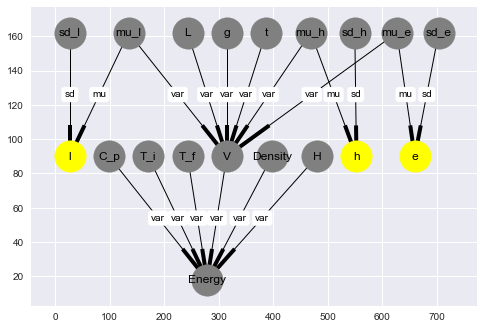

In [24]:
# %load tests/welding.py

from pymcnet.net import *
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Synthetic Data-set (observations)
np.random.seed(19806) #random.org

num_obs = 100
l_obs = norm(8.5*1e-3, 0.5*1e-3).rvs(size=100)
h_obs = norm(2.6*1e-3, 0.5*1e-3).rvs(size=100)
e_obs = norm(11.*1e-3, 1.*1e-3).rvs(size=100)
synth = pd.DataFrame(data=np.array([l_obs, h_obs, e_obs]).T, columns=['l','h','e'])
# for i in [l_obs, h_obs, e_obs]:
#     sns.distplot(i)
# plt.legend([
#     'l_obs',
#     'h_obs',
#     'e_obs'
# ])

n_samp = 10000

# import theano.tensor as T
D = BayesianNetwork()

D.add_node('mu_l', dist = pm.Uniform,
           lower=8.3e-3, upper=8.6e-3,
           dist_type='Uniform')
D.add_node('sd_l', dist = pm.Uniform,
           lower=0.2e-3, upper=0.7e-3,
           dist_type='Uniform')
D.add_node('l', dist=pm.Normal,
           mu=lambda : D.d('mu_l'),
           sd=lambda: D.d('sd_l'),
           dist_type='Normal',
           observed=synth['l'])
D.add_edge('mu_l','l', var='mu')
D.add_edge('sd_l', 'l', var='sd')

D.add_node('mu_h', dist = pm.Uniform,
           lower=2.5e-3, upper=2.8e-3,
           dist_type='Uniform')
D.add_node('sd_h', dist = pm.Uniform,
           lower=0.3e-3, upper=0.6e-3,
           dist_type='Uniform')
D.add_node('h', dist=pm.Normal,
           mu=lambda: D.d('mu_h'),
           sd=lambda: D.d('sd_h'),
           dist_type='Normal',
           observed=synth['h'])
D.add_edge('mu_h','h', var='mu')
D.add_edge('sd_h', 'h', var='sd')

D.add_node('mu_e', dist = pm.Uniform,
           lower=10e-3, upper=13e-3,
           dist_type='Uniform')
D.add_node('sd_e', dist = pm.Uniform,
           lower=0.8e-3, upper=1.3e-3,
           dist_type='Uniform')
D.add_node('e', dist=pm.Normal,
           mu=lambda: D.d('mu_e'),
           sd=lambda: D.d('sd_e'),
           dist_type='Normal',
           observed=synth['e'])
D.add_edge('mu_e','e', var='mu')
D.add_edge('sd_e', 'e', var='sd')

D.add_node('L', dist = pm.Normal,
           mu=500e-3, sd=10e-3,
           dist_type='Normal')
D.add_node('g', dist = pm.Normal,
           mu=2e-3, sd=0.1e-3,
           dist_type='Normal')
D.add_node('t', dist = pm.Normal,
           mu=15e-3, sd=0.5e-3,
           dist_type='Normal')


def vol_p():
    return D.d('L')*((3./4.)*D.d('mu_l')*D.d('mu_h') +\
                     D.d('g')*D.d('t') +\
                     (D.d('mu_l')-D.d('g'))*(D.d('t')-D.d('mu_e'))/2.)

D.add_node('V', dist=pm.Deterministic,
           var =  vol_p,
           dist_type='Deterministic')
D.add_edges_from([(i,'V') for i in ['L', 'mu_l','mu_h','g','t','mu_e']],
                 var='var')

D.add_node('Density', dist=pm.Normal,
           mu=8238., sd=10.,
          dist_type='Normal')
D.add_node('H', dist=pm.Normal,
           mu=270e3, sd=3e3,
           dist_type='Normal')
D.add_node('C_p', dist=pm.Normal,
           mu=500., sd=5.,
           dist_type='Normal')
D.add_node('T_i', dist=pm.Normal,
           mu=303., sd=.3,
           dist_type='Normal'),
D.add_node('T_f', dist=pm.Normal,
           mu=1628., sd=10.,
           dist_type='Normal')


def nrg():
    return D.d('Density')*(D.d('C_p')*(D.d('T_f')-D.d('T_i')) +\
                           D.d('H'))*D.d('V')
D.add_node('Energy', dist=pm.Deterministic,
           var = nrg,
           dist_type = 'Deterministic')

D.add_edges_from([(i, 'Energy') for i in ['Density', 'C_p',
                                         'T_f', 'T_i',
                                         'H', 'V']], var='var')

draw_net(D)

# with pm.Model() as model:
#     instantiate_pm(D)

# with model:
#     step = pm.Metropolis()
#     trace = pm.sample(n_samp, step=step)

# lims = [(8.2e-3, 8.6e-3),
#         (0.2e-3, 0.7e-3),
#         (2.5e-3, 2.8e-3),
#         (0.3e-3, 0.6e-3),
#         (10e-3, 13e-3),
#         (0.8e-3, 1.3e-3)]
# varnames=['mu_l', 'sd_l',
#           'mu_h', 'sd_h',
#           'mu_e', 'sd_e']


# def compare_dist(ax, dat, lim, scale=1.):
#     sns.distplot(scale*dat, ax=ax, kde=True, label='Posterior', kde_kws={'ls':'--'})
#     a,b = scale*lim[0], scale*lim[1]
#     y = 1./(b-a)
#     ax.hlines(y=y, xmin=a, xmax=b, linestyles=u'solid', label='Prior')
#     ax.vlines([a,b],ymin=0, ymax=y, linestyles=u'solid')
#     ax.legend()

# f, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15))

# for n, ax in enumerate(axes.flat):
#     compare_dist(ax, trace[n_samp/2:].get_values(D.d(varnames[n])), lims[n], scale=1e3)
#     ax.set_xlabel("{} x10^{}".format(varnames[n], -3))
# plt.show()

# f2 = plt.figure(figsize=(10,5))
# sns.distplot(trace[n_samp/2:].get_values('Energy')*1e-4, kde=True, label='Posterior', kde_kws={'ls':'--'})
# # sns.distplot(trace_prior[n_samp/2:].get_values('Energy')*1e-4, label='Prior', kde_kws={'color':'k'})
# plt.legend()
# plt.xlabel('Energy x10^{}'.format(4))
# plt.show()


In [33]:
D.toPMML('my_pmml.xml')

mu_l
	upper 0.0086
	lower 0.0083
sd_l
	upper 0.0007
	lower 0.0002
l
	mu unknown_func
	sd unknown_func
mu_h
	upper 0.0028
	lower 0.0025
sd_h
	upper 0.0006
	lower 0.0003
h
	mu unknown_func
	sd unknown_func
mu_e
	upper 0.013
	lower 0.01
sd_e
	upper 0.0013
	lower 0.0008
e
	mu unknown_func
	sd unknown_func
L
	mu 0.5
	sd 0.01
g
	mu 0.002
	sd 0.0001
t
	mu 0.015
	sd 0.0005
V
	var unknown_func
Density
	mu 8238.0
	sd 10.0
H
	mu 270000.0
	sd 3000.0
C_p
	mu 500.0
	sd 5.0
T_i
	mu 303.0
	sd 0.3
T_f
	mu 1628.0
	sd 10.0
Energy
	var unknown_func
Wrote PMML file to my_pmml.xml


In [19]:
dic = {'Uniform': 'UniformDistributionForBN',
       'Normal': 'NormalDistributionForBN',
       'lower': 'Lower',
       'upper': 'Upper',
       'mu': 'Mean',
       'sd': 'Variance'
      }
[dic[i] for i in ['mu', 'sd']]

['Mean', 'Variance']

In [3]:
bnp = parsers.pmml.bn.BayesianNetworkParser()

bnp.parse('BN_eg.xml')


[<Element {http://www.dmg.org/PMML-4_3}ContinuousNode at 0x8d2aac8>, <Element {http://www.dmg.org/PMML-4_3}ContinuousNode at 0x8d2ac48>, <Element {http://www.dmg.org/PMML-4_3}ContinuousNode at 0x8d2acc8>, <Element {http://www.dmg.org/PMML-4_3}ContinuousNode at 0x8d2ad08>]
C1
C2
C4
C3


In [4]:
bnp._parse_graph()

TypeError: _parse_graph() takes exactly 2 arguments (1 given)

In [45]:
import networkx as nx
G = nx.DiGraph()

In [46]:
G.add_node(0, att = 1)
G.add_node(1, att=G.node[0]['att']+1)
G.node

{0: {'att': 1}, 1: {'att': 2}}

In [47]:
G.node[0]['att'] += 1
G.node

{0: {'att': 2}, 1: {'att': 2}}

In [2]:
from pythonds.basic.stack import Stack
from pythonds.trees.binaryTree import BinaryTree

def buildParseTree(fpexp):
    fplist = fpexp.split()
    pStack = Stack()
    eTree = BinaryTree('')
    pStack.push(eTree)
    currentTree = eTree
    for i in fplist:
        if i == '(':
            currentTree.insertLeft('')
            pStack.push(currentTree)
            currentTree = currentTree.getLeftChild()
        elif i not in ['+', '-', '*', '/', ')']:
            currentTree.setRootVal(int(i))
            parent = pStack.pop()
            currentTree = parent
        elif i in ['+', '-', '*', '/']:
            currentTree.setRootVal(i)
            currentTree.insertRight('')
            pStack.push(currentTree)
            currentTree = currentTree.getRightChild()
        elif i == ')':
            currentTree = pStack.pop()
        else:
            raise ValueError
    return eTree

pt = buildParseTree("( ( 10 + 5 ) * 3 )")
pt.postorder()  #defined and explained in the next section


10
5
+
3
*
